# Super Mario Bros Gym
This is the example notebook for the seminar:

392142 Applied Cognitive Computing: Advancing Reinforcement Learning Agents through Cognitive Mechanisms

You can change any part of this colab for your group work. Simply go to File -> "Save a Copy to Drive" and start changing parts of the code.

Please don't use any reinforcement learning libraries for your group work (Stable Baselines, Chainer RL, and so on). The idea is not to simply plug in the state of the art model, but learn what works and what doesn't work by modifying an algorithm.

For example, for the group work you could:
- Change the reward model
- Change the input
- Change parts of PPO
- Change parts of the environment
- Implement a different Reinforcement Learning algorithm
- Try out non Reinforcement Learning algorithms (MDP, POMDP, Genetic Algorithms)
- Optimize part of the environment
- Try out ANY other idea you have that could help in getting mario as far as possible.


# Setup

In [3]:
! pip install gym==0.24.1 gym-super-mario-bros==7.4.0 nes_py==8.2.1 numpy==1.22.0 torch==2.2.0  torchaudio==2.2.0  torchrl==0.3.0  torchvision==0.17.0  tqdm==4.66.5 matplotlib==3.5.2 scipy==1.11.1 mediapy



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 696.4/696.4 kB 14.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.7/77.7 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 79.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 24.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 5.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensordict to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still

## Checking the gpu that is provided by google colab.
If you don't see a gpu listed, or an error is shown, please click on the small dropdown arrow on the top right corner and choose "View Ressources" from the appearing menu.

From there you can click on "Change runtime type" on the bottom right.

In the appearing window, you should be able to select a "Hardware accelerator", which you will have to set to "GPU"

In [1]:
! nvidia-smi

Sun Apr 27 22:17:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# PPO Algorithm

Here we define the PPO Algorithm, that can be freely extended during the seminar.

The imports used for the PPO algorithm

In [2]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT
from datetime import datetime
import cv2
from tqdm import tqdm
import numpy as np
from gym.wrappers import GrayScaleObservation

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:20: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  device: torch.device = torch.device(torch._C._get_default_device()),  # torch.device('cpu'),


Setting the device to gpu if available

In [3]:
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()):
    device = torch.device('cuda:0')
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))

else:
    print("Device set to : cpu")
    device = torch.device("cpu")

Device set to : Tesla T4


## ActorCritic
Here we define the actor critic agent that functions as our neural network.
To get a better understanding of the algorithm you can take a look at: https://theaisummer.com/Actor_critics/

## RolloutBuffer

In [4]:
# The RolloutBuffer which keeps the training tuples.
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    # We clear the buffer after each training update
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

In [5]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        # We define if the action space is continuous or a value choosen from a set of possible actions
        self.has_continuous_action_space = has_continuous_action_space


        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        # defining the actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )
        # defining the critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )

    def set_action_std(self, new_action_std):
        #We only calculate the action std if we have a continuous action space
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError

    def act(self, state):
        # if we have a continuous action space we sample from a multivariate normal distribution
        # otherwise we calculate a categorical action spac
        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)

        return action.detach(), action_logprob.detach()

    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)

            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)

            # For Single Action Environments.
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


##PPO

In [6]:
class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs

        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                print("setting actor output action_std to : ", self.action_std)
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state.cpu())
            self.buffer.actions.append(action.cpu())
            self.buffer.logprobs.append(action_logprob.cpu())

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

##Helper Functions for the environments and rendering

In [7]:
#renders given frames with mediapy and shows a video
def renderEnv(frames):
  import mediapy as media
  media.show_video(frames,fps=60//4)

#plot for visualizing results
def plotRewardandTime(avg_norm_reward,avg_length):
  import matplotlib.pyplot as plt
  x = np.linspace(0,len(avg_reward),len(avg_reward))

  fig, axs = plt.subplots(1, 2,figsize=(9,3))

  axs[0].plot(x, avg_norm_reward)
  axs[0].set_title("avg_norm_reward")

  axs[1].plot(x, avg_length)
  axs[1].set_title("avg_length")
  plt.show()

In [8]:
import gym

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=10):
        super().__init__(env)
        self.last_x_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3
        self.stage = 1
        self.world = 1

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.count = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        x_pos = info['x_pos']

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0
            self.last_x_pos = x_pos

        if info['life'] != self.lifes or info["stage"] != self.stage or info["world"] != self.world:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']
            self.stage = info["stage"]
            self.world = info["world"]

        if self.count >= self.threshold:
            reward = -15
            done = True

        return state, reward, done, info

#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        return obs, reward_out, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)



#Training

If you want to run this for more than an hour and really test how far your model gets, I would recommend to start a local runtime on your computer/laptop.
Here is a link on how to create a local runtime: https://research.google.com/colaboratory/local-runtimes.html

--------------------------------
Epoch 40 done:
Update iterations: 4
Statistics:

Reward of best episode: 509.75
Length of best episode: 475

Average total reward: 149.0625
Average normalized reward: 0.9649638519855042
Average length: 150.375
--------------------------------


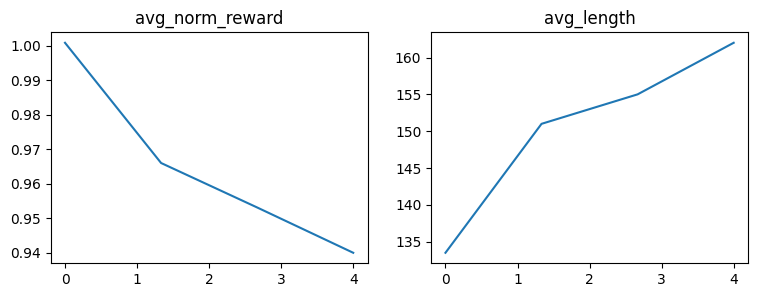

timestep: 8327 updates: 4 reward: 0.9322237342535075:   0%|          | 42/9999 [02:12<8:44:44,  3.16s/it]


KeyboardInterrupt: 

In [9]:
from IPython.core.display import clear_output


state_dim = 15360                     # state space dimension
lr_actor = 0.0003                     # learning rate for actor network
lr_critic = 0.001                     # learning rate for critic network
gamma = 0.99                          # gamma discount
K_epochs = 50                         # K value for the PPO-CLIP objective function
eps_clip = 0.2                        # the epsilon clipping value
has_continuous_action_space = False   # the mario environment doesn't have a continuous action space
action_std = None                     # we don't change the action distribution
frameskip = 4                         # the frameskip value of the environment
down_sample_rate = 4                  # downsample rate. Calculated as: original_dimension/down_sample_rate
frame_stack = 4                       # frame stacking value

env = gym_super_mario_bros.make('SuperMarioBros-v1')  #the environment. v0 is with original background, v1 has the background removed
env = JoypadSpace(env, SIMPLE_MOVEMENT)               #The Joypadspace sets the available actions. We use SIMPLE_MOVEMENT.
env = SkipFrame(env, skip=frameskip)                  #Skipframewrapper to skip some frames
env = DeadlockEnv(env,threshold=(60*2)//frameskip)                   #Deadlock environment wrapper to stop the game if mario is stuck at a pipe



action_dim = env.action_space.n # action space dimension
#state_dim = env.state_space.n  # Currently we flatten the input and therefore set the state_dim manually

ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)

# track total training time
start_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)

print("============================================================================================")

#some helper variables
time_step = 0
max_training_epochs = 10000
max_ep_len = 10000
update_timestep = max_ep_len

# We mount the google drive to save and load PPO states.
#from google.colab import drive
#drive.mount('/content/gdrive')

# If an agent is saved you can uncomment the following line to load the weights.
#ppo_agent.load("/content/gdrive/My Drive/ppo.save")

avg_reward_temp = []
avg_length_temp = []
avg_norm_reward_temp = []
avg_reward = []
avg_length = []
avg_norm_reward = []
updates = 0

episode_list = []

tbar = tqdm(range(1,max_training_epochs))
for i in tbar:
    # first we reset the state
    state = env.reset()
    current_ep_reward = 0
    # as we stack some frames, we create a buffer with empty frames for the first inputs
    states_buffer = [np.zeros((3840,)) for _ in range(3)]
    frames = []
    # the collection loop
    for t in range(1, max_ep_len):
        # Downsampling the environment
        in_state = GrayScale(Downsample(down_sample_rate,state.copy())).flatten()

        # creating the new stack for the current frame
        states_buffer.append(in_state/255)
        states_buffer = states_buffer[-frame_stack:]

        # selecting an action
        action = ppo_agent.select_action(np.asarray(states_buffer).flatten())
        #print(np.asarray(states_buffer).flatten().min(),np.asarray(states_buffer).flatten().max())

        # performing the action and receiving the information from the environments
        state, reward, done, info = env.step(action)

        # Every 10 epochs we render the environments and therefore save the state
        if not done:
            frames.append(state.copy())

        # The PPO agent needs the reward and the done state manually, as we could modify it.
        ppo_agent.buffer.rewards.append(reward)
        ppo_agent.buffer.is_terminals.append(done)

        time_step +=1
        current_ep_reward += reward

        # every update_steps (2048) we update the algorithm
        #if time_step % update_steps == 0:


        # if the run is done we break the loop
        if done:
            break
    if len(frames) > 0:
      episode_list.append((current_ep_reward,frames))



    # We collect information every run and write them to the console
    avg_reward_temp.append(current_ep_reward)
    avg_length_temp.append(t)
    tbar.set_description("timestep: " + str(time_step) + " updates: "+str(updates)+" reward: "+str(np.asarray(avg_norm_reward_temp[-50:]).mean()))
    avg_norm_reward_temp.append(current_ep_reward/max(1,t))

    # Every 10 epochs we render the current environment
    if i % 10 == 0:
      ppo_agent.update()
      updates += 1
      avg_reward.append(np.median(avg_reward_temp))
      avg_length.append(np.median(avg_length_temp))
      avg_norm_reward.append(np.median(avg_norm_reward_temp))

      if len(episode_list) > 0:

        clear_output(wait=True)
        episode_list.sort(key=lambda x: x[0]) # we sort by the received reward and pick the best run to visualize

        print("--------------------------------")
        print("Epoch",i,"done:")
        print("Update iterations:",updates)
        print("Statistics:")
        print("")
        print("Reward of best episode:",episode_list[-1][0])
        print("Length of best episode:",len(episode_list[-1][1]))
        print("")
        print("Average total reward:",np.asarray(avg_reward[-50:]).mean())
        print("Average normalized reward:",np.asarray(avg_norm_reward[-50:]).mean())
        print("Average length:",np.asarray(avg_length[-50:]).mean())
        print("--------------------------------")
        plotRewardandTime(avg_norm_reward,avg_length)

        renderEnv(episode_list[-1][1])
        episode_list = []

        #ppo_agent.save("/content/gdrive/My Drive/ppo.save")







env.close()